In [1]:
!pip install evaluate rouge_score git+https://github.com/google-research/bleurt.git bert_score
!pip install openai
!pip install datasets
!pip install evaluate nltk comet-mt unidecode
!pip install --upgrade datasets

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-iyuwfmbv
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-iyuwfmbv
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
dataset_xlcost = load_dataset("codeparrot/xlcost-text-to-code", "Python-program-level")['test']
dataset_code_x = load_dataset("google/code_x_glue_ct_code_to_text", 'python')['test']
dataset_code_search_net = load_dataset("code-search-net/code_search_net", 'python')['test']

README.md: 0.00B [00:00, ?B/s]

xlcost-text-to-code.py: 0.00B [00:00, ?B/s]

0000.parquet:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/357k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/200k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9263 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/887 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/472 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14918 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

code_search_net.py: 0.00B [00:00, ?B/s]

The repository for code-search-net/code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code-search-net/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [3]:
def split_text(example):
    example['text'] = example['text'].split('|')[0].strip()
    return example

dataset_xlcost = dataset_xlcost.map(split_text)

dataset_code_x = dataset_code_x.rename_column('docstring', 'text')

dataset_code_search_net = dataset_code_search_net.rename_column('func_documentation_string', 'text')
dataset_code_search_net = dataset_code_search_net.rename_column('func_code_string', 'code')

Map:   0%|          | 0/887 [00:00<?, ? examples/s]

In [72]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

In [32]:
system_message = {
      "role": "system",
      "content": "For each piece of code provided as input, print a very short summary of 4 pieces and nothing more. The summary should not contain newlines or dots. The number of summary outputs must exactly match the number of input code fragments, with each total value separated by a '$' symbol if there are several fragments."
    }

In [40]:
system_message = {
      "role": "system",
      "content": "For each piece of code provided as input, output. Summary and 3 possible queries for the output of this code. Summaries and queries should not contain newlines or periods. The number of final output data must exactly match the number of fragments of the input code, and each final value must be separated by a '$' symbol if there are several fragments."
    }

In [68]:
import os
import json

def save_to_json(dataset, preds, references, q1, q2, q3, left, right, filename):
    output_data = []

    for i in range(len(references)):
        # Проверка на соответствие длин всех входных данных
        if i >= len(preds) or i >= len(q1) or i >= len(q2) or i >= len(q3):
            break

        sample_idx = left + i
        sample = dataset[sample_idx]

        # Обработка основного summary
        generated_summary = preds[i].strip()
        ideal_summary = references[i].strip()

        summary_entry = {
            "ideal": ideal_summary,
            "generated": generated_summary
        }

        # Обработка запросов
        query_entries = []
        generated_queries = [q1[i].strip(), q2[i].strip(), q3[i].strip()]

        for j in range(len(generated_queries)):
            gen_q = generated_queries[j]
            query_entry = {
                f"query{j+1}": gen_q
            }
            query_entries.append(query_entry)

        # Формирование итоговой записи
        entry = {
            "code": sample.get('code', ''),
            "summary": summary_entry,
            "query": query_entries
        }
        output_data.append(entry)

    # Создание директории при необходимости
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    # Сохранение в JSON
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=2)

In [44]:
def get_summarization(system_message, model, dataset, left, right):
    codes = ""
    refs = []
    for sample in dataset.select(range(left,right)):
        codes +=sample['code'] + "\n$\n"
        refs.append(sample['text'])
    print(len(codes))
    # print(codes)
    completion = client.chat.completions.create(
        model = model,
        messages=[
          system_message,
          {
            "role": "user",
            "content": codes
          }
        ]
    )
    summary = completion.choices[0].message.content.split('$')

    return summary, refs

In [9]:
def calculate_metrics(preds, refs):
    rouge_result = rouge.compute(predictions=preds, references=refs, rouge_types=["rougeL"])["rougeL"]
    bleu_result = bleu.compute(predictions=preds, references=[[ref] for ref in refs])

    bleurt_scores = bleurt.compute(predictions=preds, references=refs)["scores"]
    avg_bleurt = sum(bleurt_scores) / len(bleurt_scores)

    bert_scores = bertscore.compute(
        predictions=preds,
        references=refs,
        lang="en",
        model_type="microsoft/deberta-large-mnli"
    )
    avg_bert_f1 = sum(bert_scores["f1"]) / len(bert_scores["f1"])


    return rouge_result, bleurt_scores, bert_scores, avg_bert_f1

In [10]:
import json
from evaluate import load
import numpy as np

# Загружаем метрики
rouge = load('rouge')
bleu = load('bleu')
bleurt = load('bleurt', checkpoint="bleurt-base-128")
bertscore = load('bertscore')
meteor = load('meteor')

def calculate_metrics_from_file(json_filename):
    with open(json_filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    references = [entry["ideal_answer"] for entry in data]
    predictions = [entry["generated_answer"] for entry in data]
    codes = [entry["code"] for entry in data]

    # --- ROUGE ---
    rouge_types = ["rouge1", "rouge2", "rougeL"]
    rouge_results = rouge.compute(predictions=predictions, references=references, rouge_types=rouge_types)

    # --- BLEU ---
    # Вычисляем BLEU для каждого примера индивидуально
    bleu_per_example = []
    for pred, ref in zip(predictions, references):
        if not pred or not ref:  # Обработка пустых строк
            bleu_per_example.append(0.0)
            continue
        result = bleu.compute(predictions=[pred], references=[[ref]])
        bleu_per_example.append(result["bleu"])

    bleu_result = np.mean(bleu_per_example)
    max_bleu = np.max(bleu_per_example)
    min_bleu = np.min(bleu_per_example)

    # --- BLEURT ---
    bleurt_scores = bleurt.compute(predictions=predictions, references=references)["scores"]
    avg_bleurt = np.mean(bleurt_scores)

    # --- BERTScore ---
    bert_scores = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bert_precision = np.mean(bert_scores["precision"])
    avg_bert_recall = np.mean(bert_scores["recall"])
    avg_bert_f1 = np.mean(bert_scores["f1"])

    # --- METEOR ---
    meteor_scores = meteor.compute(predictions=predictions, references=references)["meteor"]

    # Собираем примеры с кодом и метриками
    examples = []
    for i in range(len(data)):
        examples.append({
            "code": codes[i],
            "ideal_answer": references[i],
            "generated_answer": predictions[i],
            "bleu": bleu_per_example[i],
            "bleurt": bleurt_scores[i],
            "bert_precision": bert_scores["precision"][i],
            "bert_recall": bert_scores["recall"][i],
            "bert_f1": bert_scores["f1"][i],
            "meteor": meteor_scores[i] if isinstance(meteor_scores, list) else meteor_scores
        })

    # Находим примеры с максимальными, минимальными и средними значениями для BERTScore
    def find_extremes(metric_key):
        values = [example[metric_key] for example in examples]
        max_value = max(values)
        min_value = min(values)
        mean_value = np.mean(values)

        # Находим ближайший пример к среднему значению
        closest_to_mean_index = np.argmin([abs(v - mean_value) for v in values])

        return {
            "max": [examples[i] for i, v in enumerate(values) if v == max_value],
            "min": [examples[i] for i, v in enumerate(values) if v == min_value],
            "mean": examples[closest_to_mean_index]
        }

    bert_precision_extremes = find_extremes("bert_precision")
    bert_recall_extremes = find_extremes("bert_recall")
    bert_f1_extremes = find_extremes("bert_f1")

    # Возвращаем результаты с детализацией
    return {
        "overall_metrics": {
            "rouge1": rouge_results["rouge1"],
            "rouge2": rouge_results["rouge2"],
            "rougeL": rouge_results["rougeL"],
            "bleu": bleu_result,
            "max_bleu": max_bleu,
            "min_bleu": min_bleu,
            "avg_bleurt": avg_bleurt,
            "avg_bert_precision": avg_bert_precision,
            "avg_bert_recall": avg_bert_recall,
            "avg_bert_f1": avg_bert_f1,
            "meteor": meteor_scores
        },
        "examples": examples,
        "bert_extremes": {
            "precision": bert_precision_extremes,
            "recall": bert_recall_extremes,
            "f1": bert_f1_extremes
        }
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [11]:
import matplotlib.pyplot as plt

def plot_metrics_from_file(json_filename):
    results = calculate_metrics_from_file(json_filename)

    # Вывод BLEU статистики
    print(f"Max BLEU: {results['overall_metrics']['max_bleu']:.2f}")
    print(f"Min BLEU: {results['overall_metrics']['min_bleu']:.2f}")
    print(f"Avg BLEU: {results['overall_metrics']['bleu']:.2f}")
    print("\nExample with highest BLEU:")
    best_example = max(results["examples"], key=lambda x: x["bleu"])
    print(f"Code: {best_example['code']}")
    print(f"Ideal: {best_example['ideal_answer']}")
    print(f"Generated: {best_example['generated_answer']}")
    print(f"BLEU: {best_example['bleu']:.2f}")
    print("\n\nExample with smallest BLEU:")
    worst_example = min(results["examples"], key=lambda x: x["bleu"])
    print(f"Code: {worst_example['code']}")
    print(f"Ideal: {worst_example['ideal_answer']}")
    print(f"Generated: {worst_example['generated_answer']}")
    print(f"BLEU: {worst_example['bleu']:.2f}")

    # Функция для поиска примеров с экстремальными значениями метрики
    def find_extreme_examples(metric_key):
        examples = results["examples"]
        max_example = max(examples, key=lambda x: x[metric_key])
        min_example = min(examples, key=lambda x: x[metric_key])
        avg_value = sum(x[metric_key] for x in examples) / len(examples)
        closest_to_avg = min(examples, key=lambda x: abs(x[metric_key] - avg_value))
        return max_example, min_example, closest_to_avg, avg_value

    # BERT Recall статистика
    max_recall, min_recall, avg_recall, avg_recall_value = find_extreme_examples("bert_recall")
    print(f"\nMax Avg BERT Recall: {max_recall['bert_recall']:.2f}")
    print(f"Min Avg BERT Recall: {min_recall['bert_recall']:.2f}")
    print(f"Avg Avg BERT Recall: {avg_recall_value:.2f}")
    print("\nExample with highest Avg BERT Recall:")
    print(f"Code: {max_recall['code']}")
    print(f"Ideal: {max_recall['ideal_answer']}")
    print(f"Generated: {max_recall['generated_answer']}")
    print(f"BERT Recall: {max_recall['bert_recall']:.2f}")
    print("\nExample with smallest Avg BERT Recall:")
    print(f"Code: {min_recall['code']}")
    print(f"Ideal: {min_recall['ideal_answer']}")
    print(f"Generated: {min_recall['generated_answer']}")
    print(f"BERT Recall: {min_recall['bert_recall']:.2f}")
    print("\nExample closest to Avg BERT Recall:")
    print(f"Code: {avg_recall['code']}")
    print(f"Ideal: {avg_recall['ideal_answer']}")
    print(f"Generated: {avg_recall['generated_answer']}")
    print(f"BERT Recall: {avg_recall['bert_recall']:.2f}")

    # BERT F1 статистика
    max_f1, min_f1, avg_f1, avg_f1_value = find_extreme_examples("bert_f1")
    print(f"\nMax Avg BERT F1: {max_f1['bert_f1']:.2f}")
    print(f"Min Avg BERT F1: {min_f1['bert_f1']:.2f}")
    print(f"Avg Avg BERT F1: {avg_f1_value:.2f}")
    print("\nExample with highest Avg BERT F1:")
    print(f"Code: {max_f1['code']}")
    print(f"Ideal: {max_f1['ideal_answer']}")
    print(f"Generated: {max_f1['generated_answer']}")
    print(f"BERT F1: {max_f1['bert_f1']:.2f}")
    print("\nExample with smallest Avg BERT F1:")
    print(f"Code: {min_f1['code']}")
    print(f"Ideal: {min_f1['ideal_answer']}")
    print(f"Generated: {min_f1['generated_answer']}")
    print(f"BERT F1: {min_f1['bert_f1']:.2f}")
    print("\nExample closest to Avg BERT F1:")
    print(f"Code: {avg_f1['code']}")
    print(f"Ideal: {avg_f1['ideal_answer']}")
    print(f"Generated: {avg_f1['generated_answer']}")
    print(f"BERT F1: {avg_f1['bert_f1']:.2f}")

    # Извлекаем все метрики из результатов
    metrics = [
        "ROUGE-1",
        "ROUGE-2",
        "ROUGE-L",
        "BLEU",
        "Avg BLEURT",
        "Avg BERTScore F1",
        "Avg BERTScore Precision",
        "Avg BERTScore Recall",
        "METEOR"
    ]
    scores = [
        results["overall_metrics"]["rouge1"],
        results["overall_metrics"]["rouge2"],
        results["overall_metrics"]["rougeL"],
        results["overall_metrics"]["bleu"],
        results["overall_metrics"]["avg_bleurt"],
        results["overall_metrics"]["avg_bert_f1"],
        results["overall_metrics"]["avg_bert_precision"],
        results["overall_metrics"]["avg_bert_recall"],
        results["overall_metrics"]["meteor"]
    ]

    # Разделяем метрики по типам для цветового кодирования
    rouge_metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
    bert_metrics = ["Avg BERTScore F1", "Avg BERTScore Precision", "Avg BERTScore Recall"]
    other_metrics = ["BLEU", "Avg BLEURT", "METEOR"]

    # Создаем цветовую схему
    colors = []
    for metric in metrics:
        if metric in rouge_metrics:
            colors.append('lightcoral')
        elif metric in bert_metrics:
            colors.append('lightskyblue')
        else:
            colors.append('skyblue')

    # Создаем график
    plt.figure(figsize=(16, 7))
    bars = plt.bar(metrics, scores, color=colors, edgecolor='black')

    # Поворот меток оси X
    plt.xticks(rotation=45, ha='right')

    # Настройка графика
    plt.title(f"All Metrics for {json_filename}", fontsize=16)
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)

    # Автоматические пределы по оси Y
    ymin = min(scores) - 0.1
    ymax = max(scores) + 0.1
    plt.ylim(ymin, ymax)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Добавляем значения над столбцами
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{score:.2f}",
            ha='center',
            fontsize=11
        )

    # Легенда
    rouge_patch = plt.Line2D([0], [0], color='lightcoral', lw=4, label='ROUGE Metrics')
    bert_patch = plt.Line2D([0], [0], color='lightskyblue', lw=4, label='BERTScore Metrics')
    other_patch = plt.Line2D([0], [0], color='skyblue', lw=4, label='Other Metrics')

    plt.legend(
        handles=[rouge_patch, bert_patch, other_patch],
        loc='upper right',
        fontsize=11,
        frameon=True,
        shadow=True
    )

    plt.tight_layout()
    plt.show()

In [51]:
system_message1 = {
      "role": "system",
      "content": "For each piece of code provided as input, print a very short summary. A resume should not contain new lines or dots. The number of final output data must exactly match the number of fragments of the input code, and each final value must be separated by a '$' symbol if there are several fragments."
    }

In [59]:
system_message2 = {
      "role": "system",
      "content": "For each piece of code provided as input, print a short possible text query to receive this code in the response, the query must not contain new lines or dots. The number of final output data must exactly match the number of fragments of the input code, and each final value must be separated by a '$' symbol if there are several fragments."
    }

In [ ]:
system_message = {
      "role": "system",
      "content": "For each piece of code provided as input, print a very short summary of 4 pieces and nothing more. The summary should not contain newlines or dots. The number of summary outputs must exactly match the number of input code fragments, with each total value separated by a '$' symbol if there are several fragments."
    }

In [73]:
preds1, refs = get_summarization(system_message1, "deepseek/deepseek-chat-v3-0324:free", dataset_xlcost, 0, 20)
if len(preds1)>len(refs):
    preds1 = preds1[:len(refs)]
print(preds1)
q1, refs = get_summarization(system_message2, "deepseek/deepseek-chat-v3-0324:free", dataset_xlcost, 0, 20)
q2, refs = get_summarization(system_message2, "deepseek/deepseek-chat-v3-0324:free", dataset_xlcost, 0, 20)
q3, refs = get_summarization(system_message2, "deepseek/deepseek-chat-v3-0324:free", dataset_xlcost, 0, 20)
save_to_json(dataset_xlcost, preds1, refs, q1, q2, q3, 0, 20, "xlocst-deepseek/deepseek-chat-v3-0324:free.json")
# plot_metrics_from_file("xlocst-meta-llama.json")



12771
['Function to find minimal sum by removing duplicates from array', 'Function to find maximal adjacent differences in array', 'Recursive function to count ones in a specific range', 'Function to find minimal divisor and print result', "Function to find maximum LCM in Landau's function", 'Check if a number is prime', 'Check if array has at least k odd elements with matching parity', 'Function to compute a complex mathematical result from array', 'Function to insert elements based on XOR and sum conditions', 'Check if a equals c without considering b', 'Check if N+1 is a perfect square', 'Count values of i where n reduced to 1 using operations', 'Print K numbers summing to N', 'Find Nth smallest number with specific digit conditions', 'Find nearest perfect square to a number', 'Print pi with N decimal precision', 'Toggle k-th bit of a number and return new value', 'Precompute factorial results for queries', 'Find Nth term divisible by a, b, or c', 'Calculate angle within a polygon w

In [34]:
print(len(preds1))

20


49844
Max BLEU: 0.88
Min BLEU: 0.00
Avg BLEU: 0.17

Example with highest BLEU:
Code: from math import * NEW_LINE def isPerfectSquare ( x ) : NEW_LINE INDENT sr = sqrt ( x ) NEW_LINE return ( ( sr - floor ( sr ) ) == 0 ) NEW_LINE DEDENT def checkSunnyNumber ( N ) : NEW_LINE INDENT if ( isPerfectSquare ( N + 1 ) ) : NEW_LINE INDENT print ( " Yes " ) NEW_LINE DEDENT else : NEW_LINE INDENT print ( " No " ) NEW_LINE DEDENT DEDENT if __name__ == ' _ _ main _ _ ' : NEW_LINE INDENT N = 8 NEW_LINE checkSunnyNumber ( N ) NEW_LINE DEDENT
Ideal: Splicing URLs according to video ID to get video details
Generated: splicing URLs according to video ID to get video details
BLEU: 0.88


Example with smallest BLEU:
Code: def minSum ( A , N ) : NEW_LINE INDENT mp = { } NEW_LINE sum = 0 NEW_LINE for i in range ( N ) : NEW_LINE INDENT sum += A [ i ] NEW_LINE if A [ i ] in mp : NEW_LINE INDENT mp [ A [ i ] ] += 1 NEW_LINE DEDENT else : NEW_LINE INDENT mp [ A [ i ] ] = 1 NEW_LINE DEDENT DEDENT minSum = float 

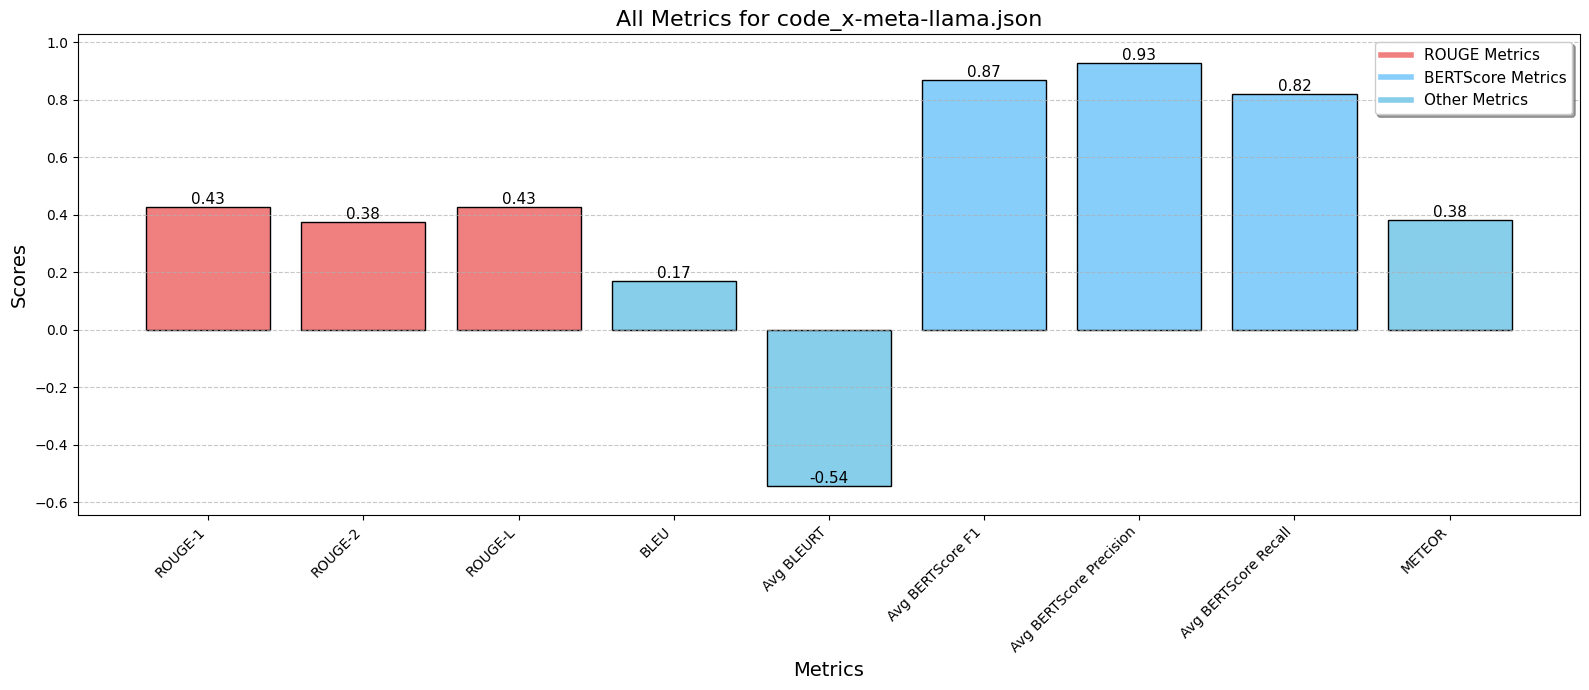

In [ ]:
preds, refs = get_summarization(system_message1, "meta-llama/llama-4-maverick:free", dataset_code_x , 0, 50)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
save_to_json(dataset_xlcost, preds, refs, 0, 50, "code_x-meta-llama.json")
plot_metrics_from_file("code_x-meta-llama.json")


39963
Max BLEU: 0.45
Min BLEU: 0.00
Avg BLEU: 0.05

Example with highest BLEU:
Code: MAX = 1000000 NEW_LINE MOD = 10 ** 9 + 7 NEW_LINE result = [ 0 for i in range ( MAX + 1 ) ] NEW_LINE fact = [ 0 for i in range ( MAX + 1 ) ] NEW_LINE def preCompute ( ) : NEW_LINE INDENT fact [ 0 ] = 1 NEW_LINE result [ 0 ] = 1 NEW_LINE for i in range ( 1 , MAX + 1 ) : NEW_LINE INDENT fact [ i ] = ( ( fact [ i - 1 ] % MOD ) * i ) % MOD NEW_LINE result [ i ] = ( ( result [ i - 1 ] % MOD ) * ( fact [ i ] % MOD ) ) % MOD NEW_LINE DEDENT DEDENT def performQueries ( q , n ) : NEW_LINE INDENT preCompute ( ) NEW_LINE for i in range ( n ) : NEW_LINE INDENT print ( result [ q [ i ] ] ) NEW_LINE DEDENT DEDENT q = [ 4 , 5 ] NEW_LINE n = len ( q ) NEW_LINE performQueries ( q , n ) NEW_LINE
Ideal: Print a log message to standard error.
Generated: print_log prints log message to standard error
BLEU: 0.45


Example with smallest BLEU:
Code: def findSize ( N ) : NEW_LINE INDENT if ( N == 0 ) : NEW_LINE INDENT return 1

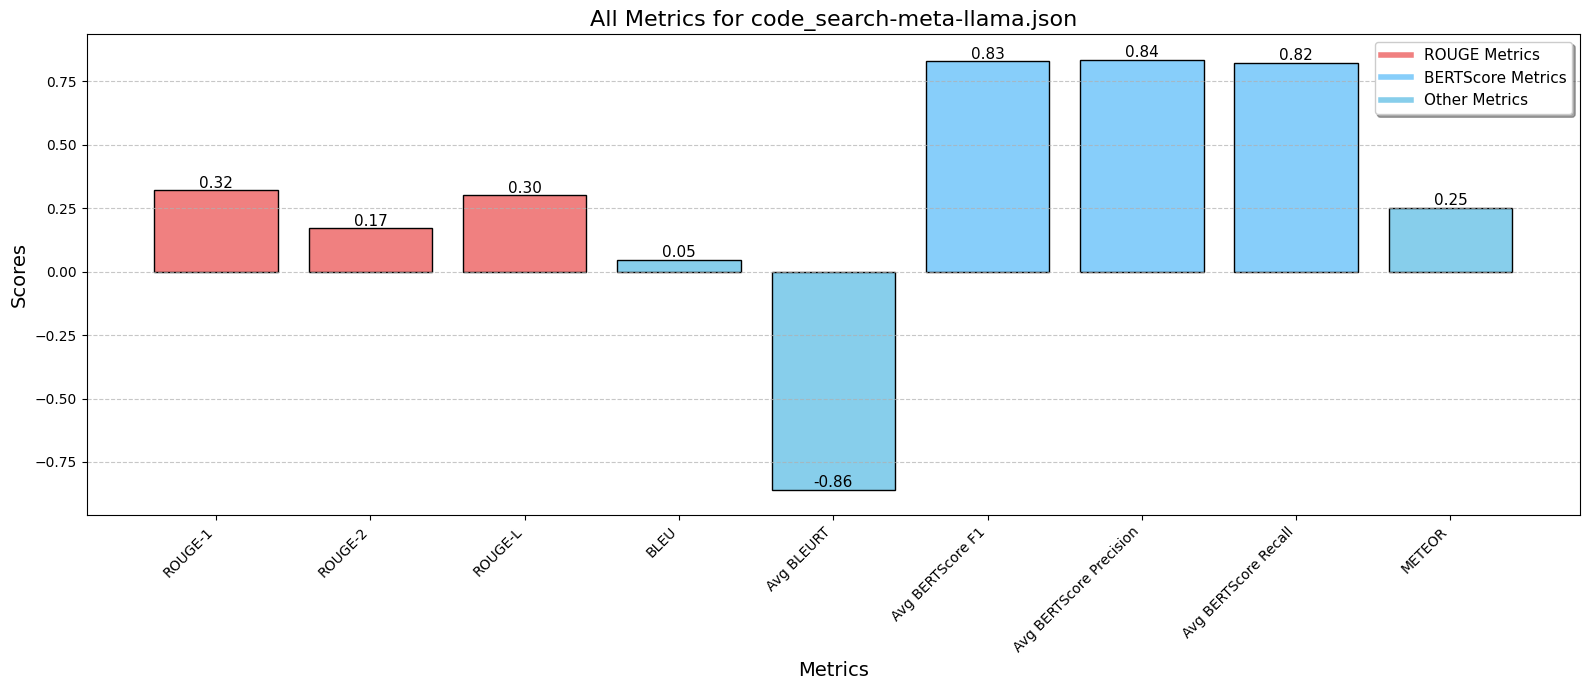

In [ ]:
preds, refs = get_summarization("meta-llama/llama-4-maverick:free", dataset_code_search_net , 0, 50)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
save_to_json(dataset_xlcost, preds, refs, 0, 50, "code_search-meta-llama.json")
plot_metrics_from_file("code_search-meta-llama.json")

